In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import plotly.graph_objects as go

from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
from typing import List
from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# Updated read_data function
def read_data(file_path, label_column):
    df = pd.read_csv(file_path)
    
    # Handle missing values
    df.replace('?', np.nan, inplace=True)
    df.fillna(df.median(numeric_only=True), inplace=True)

    # Convert categorical columns to numerical values if needed
    for column in df.select_dtypes(include='object').columns:
        df[column] = df[column].astype('category').cat.codes

    # Split data into features and labels
    labels = df[label_column].values
    features = df.drop(columns=[label_column]).values

    # Normalize the data
    features = (features - features.mean(axis=0)) / features.std(axis=0)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32).view(-1, 1)

    return features, labels

def age_cat(age):
    if age < 12:
        return "Child"
    elif age < 20:
        return "Teen"
    elif age < 30:
        return "20's"
    elif age < 40:
        return "30's"
    elif age < 50:
        return "40's"
    elif age < 60:
        return "50's"
    elif age < 70:
        return "60's"
    else:
        return "70+"

cols_to_convert = ['Number of sexual partners', 'First sexual intercourse', 'Num of pregnancies', 'Smokes',
                   'Smokes (years)', 'Smokes (packs/year)', 'Hormonal Contraceptives',
                   'Hormonal Contraceptives (years)', 'IUD', 'IUD (years)', 'STDs', 'STDs (number)',
                   'STDs:condylomatosis', 'STDs:cervical condylomatosis', 'STDs:vaginal condylomatosis',
                   'STDs:vulvo-perineal condylomatosis', 'STDs:syphilis', 'STDs:pelvic inflammatory disease',
                   'STDs:genital herpes', 'STDs:molluscum contagiosum', 'STDs:AIDS', 'STDs:HIV', 'STDs:Hepatitis B',
                   'STDs:HPV', 'STDs: Time since first diagnosis',
                   'STDs: Time since last diagnosis']

def read_multi_label_data(file_path, label_columns):
    risk_factor_df = pd.read_csv(file_path)
    
    # Handle missing values
    risk_factor_df[cols_to_convert] = risk_factor_df[cols_to_convert].apply(pd.to_numeric, errors="coerce")
    risk_factor_df[cols_to_convert].fillna(np.nan, inplace=True)
    imp = SimpleImputer(strategy="median")
    X = imp.fit_transform(risk_factor_df)
    risk_factor_df = pd.DataFrame(X, columns=list(risk_factor_df.columns))
    
    risk_factor_df["Age"] = risk_factor_df["Age"].astype(int)
    risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

    dx_cancer = px.histogram(risk_factor_df, y="Dx:Cancer")
    dx_cancer.update_layout(bargap=0.2)
    dx_cancer.update_layout(title = "Imbalanced Classes")
    
    X = risk_factor_df.drop(["Dx:Cancer", "age_cat"], axis=1)
    y = risk_factor_df["Dx:Cancer"].copy()
    adasyn = ADASYN(random_state=42)
    x_adasyn,y_adasyn = adasyn.fit_resample(X,y)
    risk_factor_df = x_adasyn.join(y_adasyn)
    risk_factor_df["age_cat"] = risk_factor_df["Age"].apply(age_cat)

    # Convert categorical columns to numerical values if needed
    for column in risk_factor_df.select_dtypes(include='object').columns:
        risk_factor_df[column] = risk_factor_df[column].astype('category').cat.codes

    # Split data into features and labels
    labels = risk_factor_df[label_columns].values
    features = risk_factor_df.drop(columns=label_columns).values

    # Normalize the data
    scaler = StandardScaler()
    features = scaler.fit_transform(features)

    # Convert to PyTorch tensors
    features = torch.tensor(features, dtype=torch.float32)
    labels = torch.tensor(labels, dtype=torch.float32)

    return features, labels

# Custom dataset class
class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Function to create a DataLoader
def create_dataloader(features, labels, batch_size=32):
    dataset = TabularDataset(features, labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# FCN model definition
class FCN(nn.Module):
    def __init__(self):
        super(FCN, self).__init__()
        self.fc1 = nn.Linear(35, 128)  # Input size is the number of features
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 1)  # Output size for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

# FCN model definition for multilabel classification
class FCN_multi(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(FCN_multi, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)
        self.fc3 = nn.Linear(64, output_dim)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = torch.sigmoid(self.fc3(x))  # Sigmoid activation for multi-label classification
        return x


**MedFusionNet - Binary**

**MedFusionNet Multi**

In [4]:
from imblearn.metrics import geometric_mean_score
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import multilabel_confusion_matrix
import plotly.express as px
from imblearn.over_sampling import SMOTE, ADASYN


# File path and label columns
file_path = '/kaggle/input/risk-factors-cervical-cancer/risk_factors_cervical_cancer.csv'
label_columns = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy'] 

train_features, train_labels = read_multi_label_data(file_path, label_columns)

# Convert back to PyTorch tensors
train_features_resampled = torch.tensor(train_features, dtype=torch.float32)
train_labels_resampled = torch.tensor(train_labels, dtype=torch.float32)

# Create DataLoader for resampled data
train_loader = create_dataloader(train_features_resampled, train_labels_resampled)


# Initialize the model, criterion, and optimizer
input_size = train_features_resampled.shape[1]
output_size = train_labels_resampled.shape[1]
model = FCN_multi(input_size, output_size)

# Define the class weights (if needed, adjust based on your specific class distribution)
class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0])  # Update with actual weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    outputs = model(train_features_resampled)
    # Define your custom thresholds
    thresholds = [0.3, 0.4, 0.6, 0.7]
    preds = torch.zeros(outputs.shape)
    for i, threshold in enumerate(thresholds):
        preds[:, i] = (outputs[:, i] > threshold).float()

# Convert preds to numpy for sklearn compatibility
preds_np = preds.numpy()
labels_np = train_labels_resampled.numpy()

# Ensure labels_np is binary (0 or 1)
# You can choose a threshold; for binary classification, 0.5 is standard
labels_binary = (labels_np > 0.5).astype(int)

# Debugging: Check shapes and types
print(f"Shape of labels_binary: {labels_binary.shape}, Type: {labels_binary.dtype}")
print(f"Shape of preds_np: {preds_np.shape}, Type: {preds_np.dtype}")
print(f"Shape of preds_binary: {preds_binary.shape}, Type: {preds_binary.dtype}")

# Classification report
try:
    print(classification_report(labels_binary, preds_binary))
except ValueError as e:
    print("Error during classification report generation:", e)

# Calculate and print overall accuracy
accuracy = accuracy_score(labels_binary, preds_binary)
print(f'Overall Accuracy: {accuracy:.4f}')

# Calculate and plot confusion matrix
conf_matrix = multilabel_confusion_matrix(labels_binary, preds_binary)
# You can visualize the confusion matrix using plotly or matplotlib
for i, cm in enumerate(conf_matrix):
    print(f'Confusion Matrix for Class {i}:\n{cm}')
    # Set up the matplotlib figure
    plt.figure(figsize=(10, 7))

    # Create a heatmap using seaborn
    diagnoses_num_partner_heatmap = px.imshow(cm,aspect="auto",
                            text_auto=True,
                            color_continuous_scale="agsunset")
    
    diagnoses_num_partner_heatmap.update_layout(
        xaxis_title='Predicted Label',
        yaxis_title='True Label',
        coloraxis_colorbar=dict(title='Confusion Matrix')  # Optional: Add a color bar title
    )
    #diagnoses_num_partner_heatmap.title('Confusion Matrix')
    diagnoses_num_partner_heatmap.show()



/tmp/ipykernel_33/917171635.py:84: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  risk_factor_df[cols_to_convert].fillna(np.nan, inplace=True)
/tmp/ipykernel_33/754284729.py:17: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).

/tmp/ipykernel_33/754284729.py:18: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



Epoch 1/20, Loss: 0.7494843602180481
Epoch 2/20, Loss: 0.717291533946991
Epoch 3/20, Loss: 0.6958606243133545
Epoch 4/20, Loss: 0.6894676685333252
Epoch 5/20, Loss: 0.6871698498725891
Epoch 6/20, Loss: 0.6919925808906555
Epoch 7/20, Loss: 0.6818406581878662
Epoch 8/20, Loss: 0.6885702610015869
Epoch 9/20, Loss: 0.6689146757125854
Epoch 10/20, Loss: 0.6691003441810608
Epoch 11/20, Loss: 0.6610240340232849
Epoch 12/20, Loss: 0.6621062755584717
Epoch 13/20, Loss: 0.6820919513702393
Epoch 14/20, Loss: 0.668136715888977
Epoch 15/20, Loss: 0.6565232276916504
Epoch 16/20, Loss: 0.6674249172210693
Epoch 17/20, Loss: 0.6511811017990112
Epoch 18/20, Loss: 0.6780747175216675
Epoch 19/20, Loss: 0.6628596186637878
Epoch 20/20, Loss: 0.6537526249885559
Shape of labels_binary: (1682, 4), Type: int64
Shape of preds_np: (1682, 4), Type: float32


NameError: name 'preds_binary' is not defined

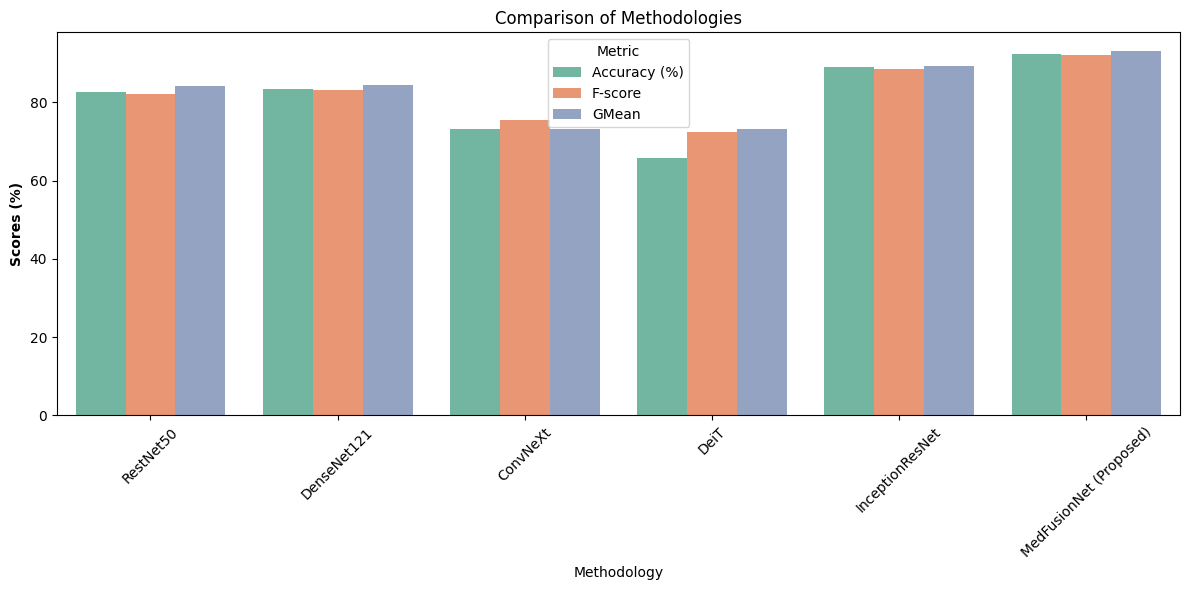

In [5]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Methodology': [
        "RestNet50",
        "DenseNet121",
        "ConvNeXt",
        "DeiT",
        "InceptionResNet",
        "MedFusionNet (Proposed)"
    ],
    'Accuracy (%)': [82.66, 83.46, 73.24, 65.86, 88.93, 92.34],
    'F-score': [82.11, 83.14, 75.43, 72.34, 88.56, 92.13],
    'GMean': [84.23, 84.34, 73.21, 73.12, 89.31, 93.22]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for Seaborn
df_melted = df.melt(id_vars='Methodology', var_name='Metric', value_name='Score')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Methodology', y='Score', hue='Metric', data=df_melted, palette='Set2')

# Add labels and title
plt.ylabel('Scores (%)', fontweight='bold')
plt.title('Comparison of Methodologies')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


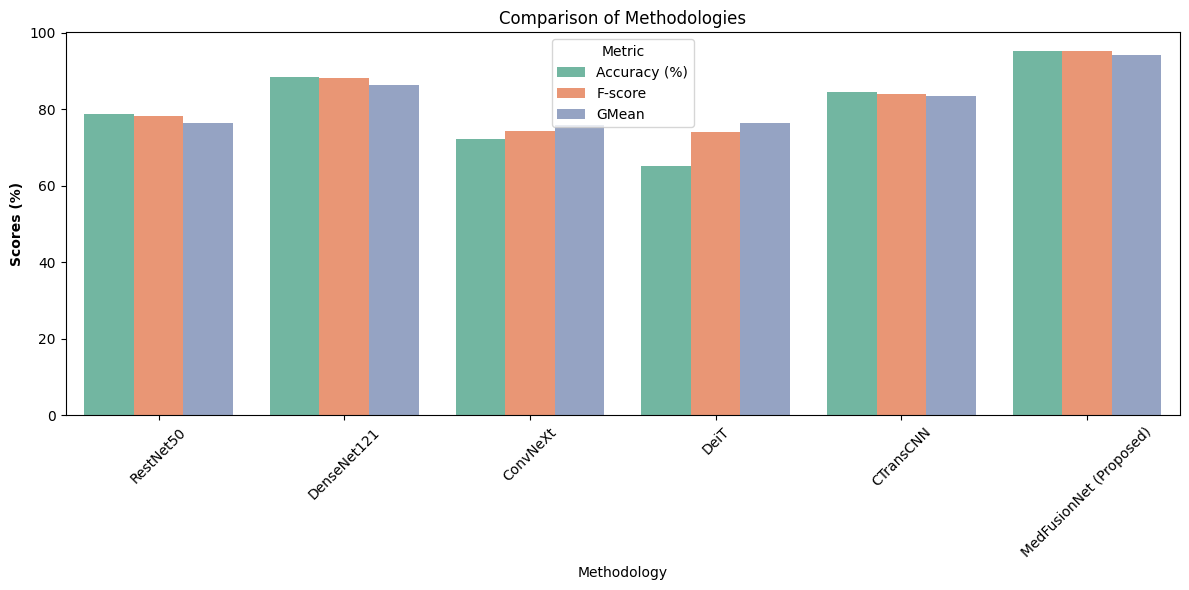

In [6]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Data
data = {
    'Methodology': [
        "RestNet50",
        "DenseNet121",
        "ConvNeXt",
        "DeiT",
        "CTransCNN",
        "MedFusionNet (Proposed)"
    ],
    'Accuracy (%)': [78.87, 88.35,72.34,65.09,84.56,95.35],
    'F-score': [78.23,88.11,74.33,74.09,84.12,95.16],
    'GMean': [76.43,86.23,75.96,76.32,83.37,94.32]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Melt the DataFrame for Seaborn
df_melted = df.melt(id_vars='Methodology', var_name='Metric', value_name='Score')

# Create the bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='Methodology', y='Score', hue='Metric', data=df_melted, palette='Set2')

# Add labels and title
plt.ylabel('Scores (%)', fontweight='bold')
plt.title('Comparison of Methodologies')
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()


In [7]:
acc_comparison = px.bar(summary_df, x="Classifier Name",
                        y=col_names[1:len(col_names)],
                        color_discrete_sequence=["deeppink",
                                                 "deepskyblue",
                                                 "darkviolet",
                                                 "darkorange"],
                        barmode="group")
acc_comparison.show()

NameError: name 'summary_df' is not defined

In [8]:
# File path and label column
file_path = '/kaggle/input/risk-factors-cervical-cancer/risk_factors_cervical_cancer.csv'
label_column = 'Biopsy'
#label_columns = ['Hinselmann', 'Schiller', 'Citology', 'Biopsy'] 

# Read and process data
data, labels = read_data(file_path, label_column)
#data, labels = read_multi_label_data(file_path, label_columns)
train_size = int(0.8 * len(data))
train_features, test_features = data[:train_size], data[train_size:]
train_labels, test_labels = labels[:train_size], labels[train_size:]

# Create dataset and dataloader
train_dataset = TabularDataset(train_features, train_labels)
test_dataset = TabularDataset(test_features, test_labels)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, criterion, and optimizer
model = FCN()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 50
for epoch in range(epochs):
    model.train()
    for batch_features, batch_labels in train_loader:
        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')

# Evaluation
model.eval()
all_labels = []
all_outputs = []
with torch.no_grad():
    for batch_features, batch_labels in test_loader:
        outputs = model(batch_features)
        all_labels.append(batch_labels)
        all_outputs.append(outputs.round())  # Convert probabilities to binary outputs

# Concatenate all batch results
all_labels = torch.cat(all_labels).numpy()
all_outputs = torch.cat(all_outputs).numpy()

# Calculate metrics
accuracy = accuracy_score(all_labels, all_outputs)
precision = precision_score(all_labels, all_outputs)
recall = recall_score(all_labels, all_outputs)
f1 = f1_score(all_labels, all_outputs)
cm = confusion_matrix(all_labels, all_outputs)
    
tn, fp, fn, tp = cm.ravel()
g_mean = np.sqrt((tp / (tp + fn)) * (tn / (tn + fp)))

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'G-Mean: {g_mean:.4f}')

Epoch [1/10], Loss: 0.4950
Epoch [2/10], Loss: 0.3783
Epoch [3/10], Loss: 0.1513
Epoch [4/10], Loss: 0.0096
Epoch [5/10], Loss: 0.0473
Epoch [6/10], Loss: 0.0124
Epoch [7/10], Loss: 0.0146
Epoch [8/10], Loss: 0.0040
Epoch [9/10], Loss: 0.2542
Epoch [10/10], Loss: 0.0029
Epoch [11/10], Loss: 0.1313
Epoch [12/10], Loss: 0.0058
Epoch [13/10], Loss: 0.2692
Epoch [14/10], Loss: 0.0134
Epoch [15/10], Loss: 0.1085
Epoch [16/10], Loss: 0.0069
Epoch [17/10], Loss: 0.0045
Epoch [18/10], Loss: 0.0168
Epoch [19/10], Loss: 0.0013
Epoch [20/10], Loss: 0.0031
Epoch [21/10], Loss: 0.0217
Epoch [22/10], Loss: 0.0698
Epoch [23/10], Loss: 0.0030
Epoch [24/10], Loss: 0.0022
Epoch [25/10], Loss: 0.0577
Epoch [26/10], Loss: 0.3583
Epoch [27/10], Loss: 0.0325
Epoch [28/10], Loss: 0.0123
Epoch [29/10], Loss: 0.0181
Epoch [30/10], Loss: 0.0011
Epoch [31/10], Loss: 0.0418
Epoch [32/10], Loss: 0.0043
Epoch [33/10], Loss: 0.0095
Epoch [34/10], Loss: 0.0031
Epoch [35/10], Loss: 0.0038
Epoch [36/10], Loss: 0.0003
E

**Data Visualization**

In [9]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = df.dataframeName
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()

# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [23]:
# File path and label columns
nRowsRead = 1000 # specify 'None' if want to read whole file
file_path = '/kaggle/input/risk-factors-cervical-cancer-new/risk_factors_cervical_cancer.csv'
df = pd.read_csv(file_path)
df.dataframeName = 'kag_risk_factors_cervical_cancer.csv'
nRow, nCol = df.shape
print(nRow, nCol)


858 36


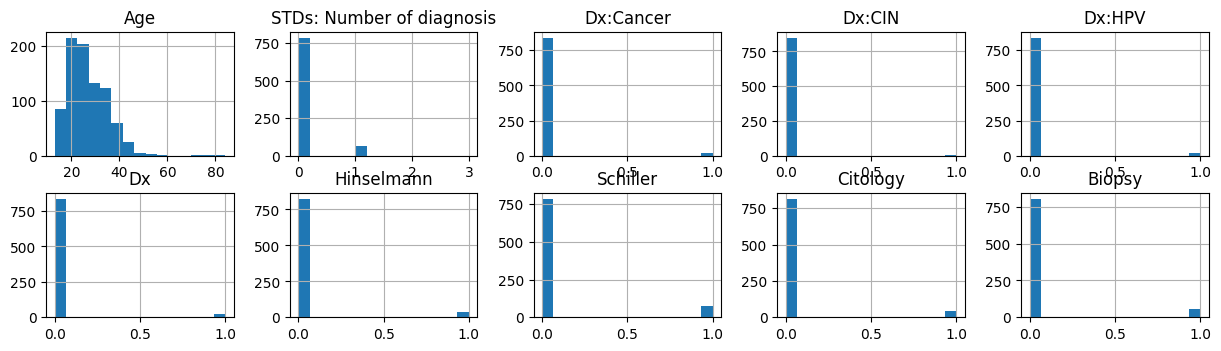

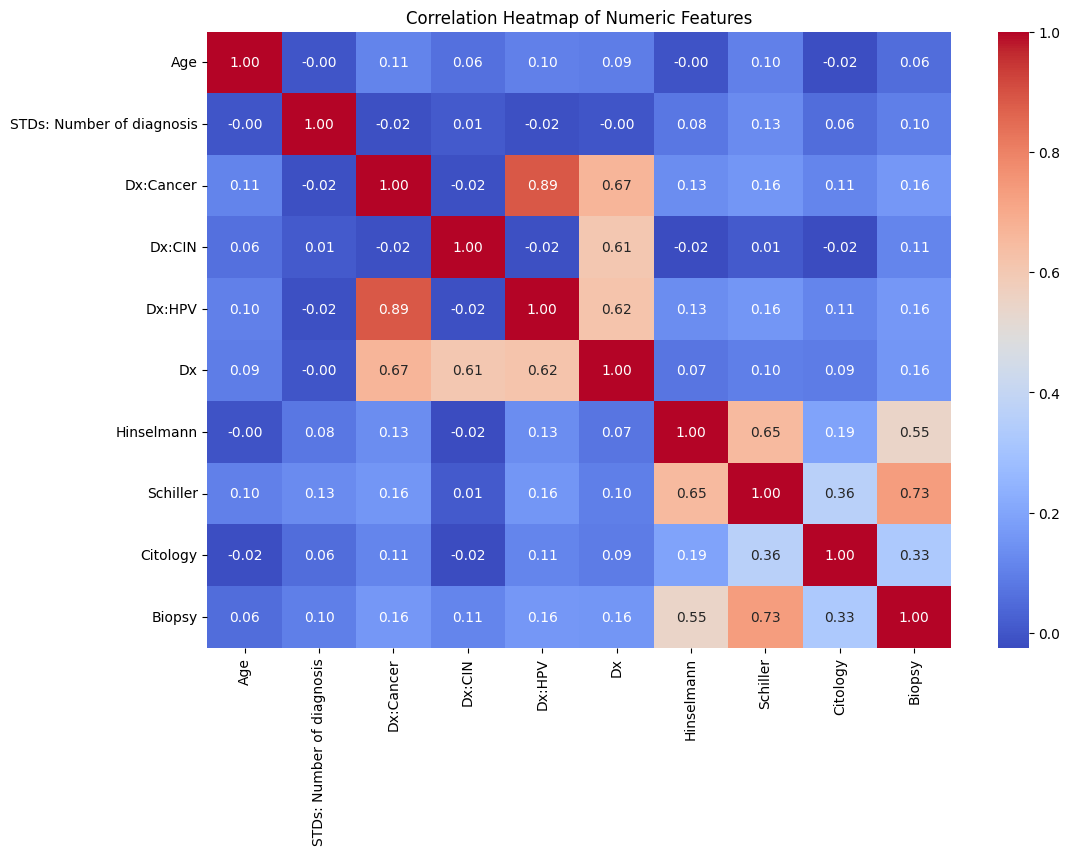

(Age                                   0
 Number of sexual partners             0
 First sexual intercourse              0
 Num of pregnancies                    0
 Smokes                                0
 Smokes (years)                        0
 Smokes (packs/year)                   0
 Hormonal Contraceptives               0
 Hormonal Contraceptives (years)       0
 IUD                                   0
 IUD (years)                           0
 STDs                                  0
 STDs (number)                         0
 STDs:condylomatosis                   0
 STDs:cervical condylomatosis          0
 STDs:vaginal condylomatosis           0
 STDs:vulvo-perineal condylomatosis    0
 STDs:syphilis                         0
 STDs:pelvic inflammatory disease      0
 STDs:genital herpes                   0
 STDs:molluscum contagiosum            0
 STDs:AIDS                             0
 STDs:HIV                              0
 STDs:Hepatitis B                      0
 STDs:HPV       

In [24]:
# Check for missing values in the dataset
missing_values = df.isnull().sum()

# Get an overall statistical summary of the data
description = df.describe()

# Plot histograms of each numeric feature to show the distribution
numeric_columns = df.select_dtypes(include=np.number).columns
df[numeric_columns].hist(bins=15, figsize=(15, 10), layout=(5, 5))

# Show correlations between numeric variables using a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_columns].corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Numeric Features')
plt.show()

missing_values, description